In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
from collections import defaultdict
import datetime
import importlib
from simulator.models import Client, SimulationAlchemy as Simulation
from tools.gamma_estimator import Engine

from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count
import logging
import sys, os
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat, df_round_time
import scipy.optimize

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [2]:
items = client.get_simulation_groups(["ER 3.303.weak.lammps"] )[:]

In [3]:
len(items)

1200

In [4]:
item = items[0]
potential_a = 0.5*(1/item.a+1/item.b)

shift = 5000
wide=2000
dt1 = 1000
dt2 = 8000

In [5]:
def parallel_step(item, progress=False):
    engine = Engine(item, shift, wide)
#     engine.load_vc()
#     engine.generate_time_points(dt1, dt2)
#     engine.calc_acs(progress=progress)
#     engine.delete_vc()
    if engine.load(acs=False) is False:
        return None
    return engine
engines = [parallel_step(item) for item in tqdm(items)]
engines = [engine for engine in engines if engine is not None]
engine = engines[0]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [6]:
len(engines)

1043

In [5]:
def f(engine):
    return [
    engine._get_gamma(W=5, estimators=[engine.gamma_3], prefix="5/"),
    engine._get_gamma(W=30, estimators=[engine.gamma_3], prefix="30/"),
    engine._get_gamma(W=50, estimators=[engine.gamma_3], prefix="50/") ,  
    engine._get_gamma(W=100, estimators=[engine.gamma_3], prefix="100/"),   
    engine._get_gamma(W=200, estimators=[engine.gamma_3], prefix="200/") ,  
    engine._get_gamma(W=500, estimators=[engine.gamma_3], prefix="500/"),
#     engine._get_gamma(W=1000, estimators=[engine.gamma_3], prefix="1000/"),
#     engine._get_gamma(W=1500, estimators=[engine.gamma_3], prefix="1500/"),
    ]

In [6]:
pool.close()
del pool

NameError: name 'pool' is not defined

In [7]:
from multiprocessing import Pool, cpu_count
pool = Pool(5)#cpu_count())

In [8]:
res_generator = pool.imap(f, engines)
gamma_data = list(tqdm(res_generator, total=len(engines)))

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
for engine, res in zip(engines, gamma_data):
    for subres in res:
        engine._apply_data(subres)

./scripts/precalc_acs/submit_job.py --group-name="ER 3.303.weak.lammps" --shift=5000 --wide=3000 --dt1=200 --dt2=5000 --W=100

In [7]:
frames = [pd.DataFrame(engine.data).set_index("t") for engine in engines]
# frames = [frame for frame in frames if "g1" in frame]

print(len(frames))

1043


In [8]:
frames[0].columns

Index(['100/crit1', '100/crit2', '100/g1', '100/g2', '100/g3', '1000/crit1',
       '1000/crit2', '1000/g1', '1000/g2', '1000/g3', '15/crit1', '15/crit2',
       '15/g1', '15/g2', '15/g3', '1500/crit1', '1500/crit2', '1500/g1',
       '1500/g2', '1500/g3', '200/crit1', '200/crit2', '200/g1', '200/g2',
       '200/g3', '30/crit1', '30/crit2', '30/g1', '30/g2', '30/g3', '5/crit1',
       '5/crit2', '5/g1', '5/g2', '5/g3', '50/crit1', '50/crit2', '50/g1',
       '50/g2', '50/g3', '500/crit1', '500/crit2', '500/g1', '500/g2',
       '500/g3', 'L', 'O', 'T'],
      dtype='object')

In [9]:
df = pd.DataFrame(concat(frames, '50/g3').mean(axis=1).loc[shift:])
df = df.set_index(df.index-shift)
df.to_csv("./g3-at-50.csv", header=None)

In [10]:
def smooth(x, y, dx):
    y_std = []
    y_mean = []
    for xc in x:
        filt = (x>xc-dx)&(x<xc+dx)
        xs = x[filt]
        ys = y[filt]
        if len(xs) >= np.inf:
            a, b, c = np.polyfit(xs, ys, 2)
            y1 = a * xs*xs + b * xs + c
            y_std.append((ys-y1).std())
            y_mean.append(a * xc*xc + b * xc + c)
        elif len(xs) >= 2:
            a, b = np.polyfit(xs, ys, 1)
            y1 = a * xs + b
            y_std.append((ys-y1).std())
            y_mean.append(a*xc + b)
        else:
            y_std.append(0)
            y_mean.append(ys[0])

    y_std = np.array(y_std)
    y_mean = np.array(y_mean)
    
    return y_mean, y_std

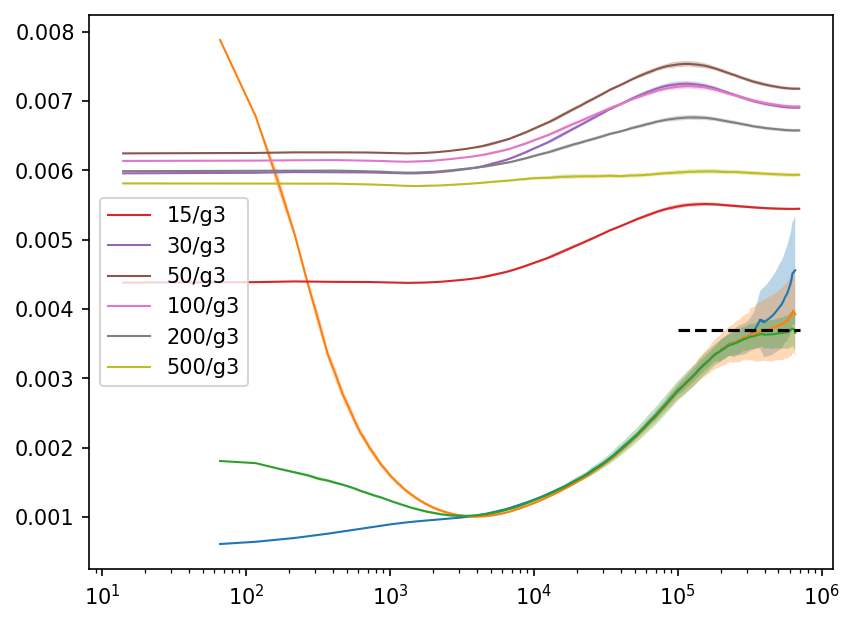

In [28]:
df_mathematica = pd.read_csv(
    "/home/ashmat/Desktop/ashmat/mathematica_exports/ERlong-523-0.0380-705000-(1200).h5.plus.csv", 
                             header=None).set_axis(["time",'noneq', '_', 'quasieq', 'T', 'O', 'L', 'fromL'], axis=1)

# sr = concat(frames, "g1", round=None).mean(axis=1).loc[shift:]
# plt.scatter(sr.index-shift, sr.values, s=3)
# sr = concat(frames, "g2", round=None).mean(axis=1).loc[shift:]
# plt.scatter(sr.index-shift, sr.values, s=3)

def smooth_plot(x, y, label=""):

    y_mean, y_std = smooth(np.log(x), y, 0.5)
    plt.plot(x, y_mean, lw=1, marker=None, ms=3, alpha=1,label=label)
    plt.fill_between(x, y_mean-1*y_std, y_mean+1*y_std,
        alpha=0.3,
    )

x = df_mathematica.time.values
y = df_mathematica.noneq.values
smooth_plot(x,y)

x = df_mathematica.time.values
y = df_mathematica.fromL.values
smooth_plot(x,y)

x = df_mathematica.time.values
y = df_mathematica.quasieq.values
smooth_plot(x,y)


# plt.plot(df_mathematica.time, df_mathematica.fromL, lw=1, marker=None, ms=3, mfc=(0,0,0,0), mec=colors[1])

for key in ['15/g3', '30/g3', '50/g3', '100/g3', '200/g3', '500/g3']:
    sr = concat(frames, key, round=None).mean(axis=1).loc[shift:]
    x = sr.index.values - shift
    y = sr.values
    smooth_plot(x,y, label=key)
#     plt.plot(sr.index-shift, sr.values, lw=0, marker=".", ms=1, alpha=1, label=key[:-3])




plt.hlines(y=0.0037, xmin=1e5, xmax=7e5, ls="--", color="k")
plt.legend()

plt.xscale("log")
# plt.yscale("log")
# plt.ylim(0.0005,0.0049)

In [18]:
len(df_mathematica)

2993

In [31]:
a = engine.a
eps = -engine.eps
O = df_mathematica.set_index("time")["O"]

g = df_mathematica.set_index("time")["quasieq"]

fact = 1/ ( 1+4 * a**4 * eps**2 / ( (a**2 - O**2) * g**2 ) )

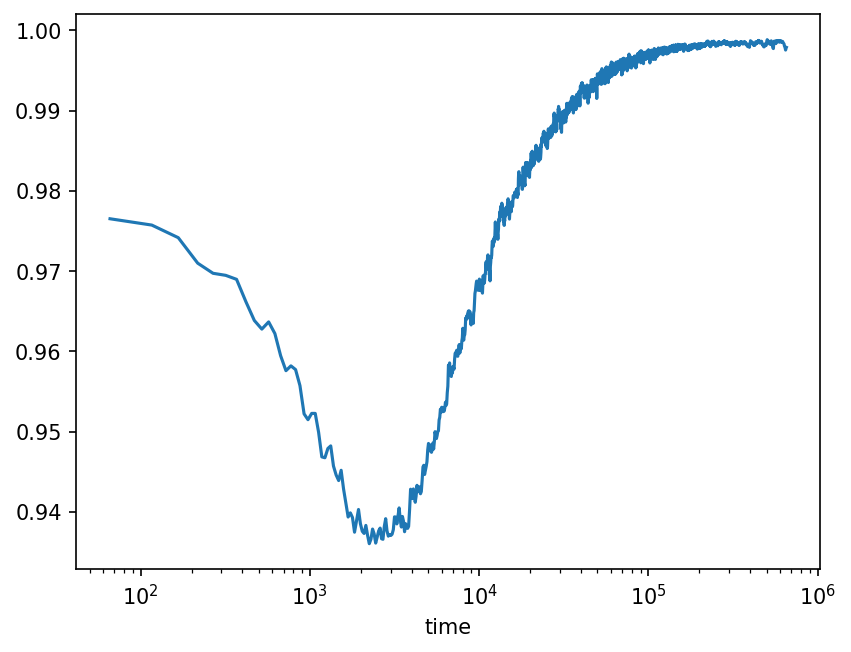

In [33]:
fact.plot()
plt.xscale("log")

In [23]:
engine.eps**2 * 

-0.0003612608774673922

In [27]:
df_mathematica.set_index("time")

,noneq,_,quasieq,T,O,L,fromL
time,,,,,,,
66.0,0.000610,66.0,0.001808,0.117225,0.171361,1978.902526,0.007879
116.5,0.000643,116.5,0.001777,0.117272,0.171357,1978.692476,0.006782
167.0,0.000670,167.0,0.001720,0.117318,0.171333,1978.455957,0.005971
217.5,0.000696,217.5,0.001620,0.117362,0.171304,1978.193839,0.005169
268.0,0.000719,268.0,0.001584,0.117425,0.171272,1977.847732,0.004300
...,...,...,...,...,...,...,...
639548.5,0.002334,639548.5,0.003192,0.333040,0.003159,27.490441,0.003948
642908.0,0.002273,642908.0,0.003066,0.333040,0.003096,26.994595,0.003810
646342.5,0.002276,646342.5,0.002916,0.333040,0.003039,26.502439,0.003741


<Axes: xlabel='time'>

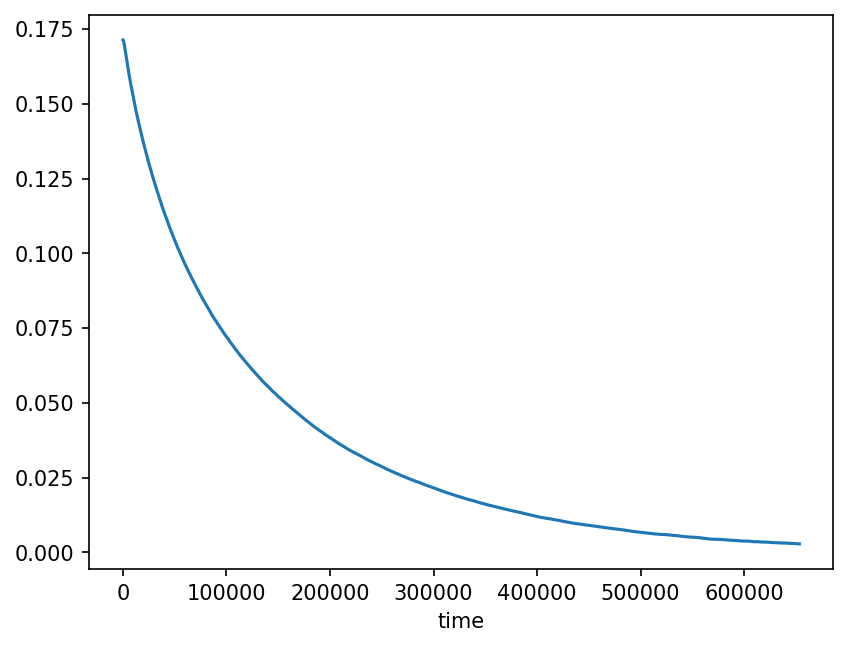

In [20]:
df_mathematica.set_index("time")["O"].plot()

In [166]:
x = df_mathematica["time"].values
y = df_mathematica["noneq"].values
# y = df_mathematica["fromL"].values
# y = y[x<480000]
# x = x[x<480000]

lx = np.log(x)

In [167]:
y_mean, y_std = smooth(lx, y, 0.4)

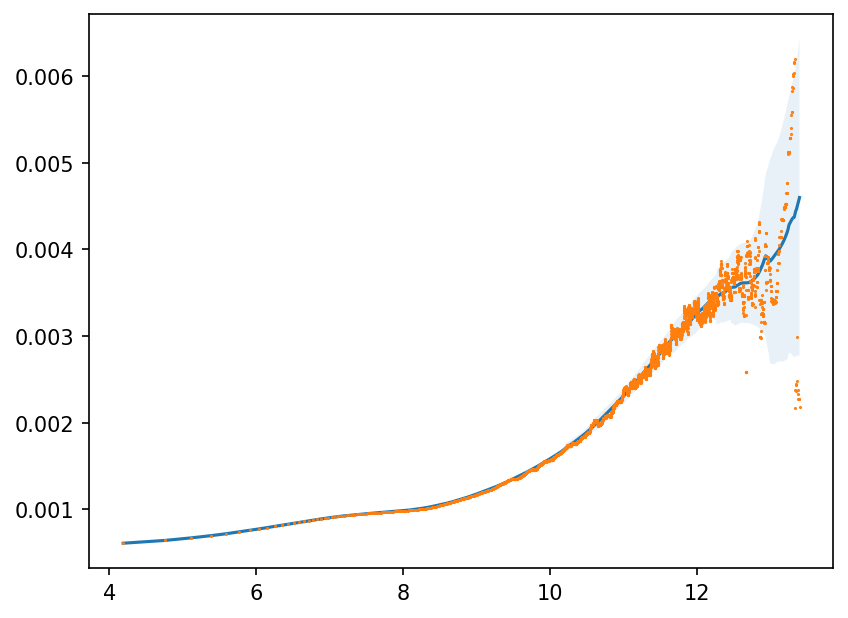

In [168]:
plt.plot(lx, y_mean)
plt.plot(lx, y, lw=0, marker=".", ms=1, alpha=1)

plt.fill_between(
    lx,
     y_mean-2*y_std,
     y_mean+2*y_std,
    alpha=0.1,
    label=r"95% confidence interval",
)

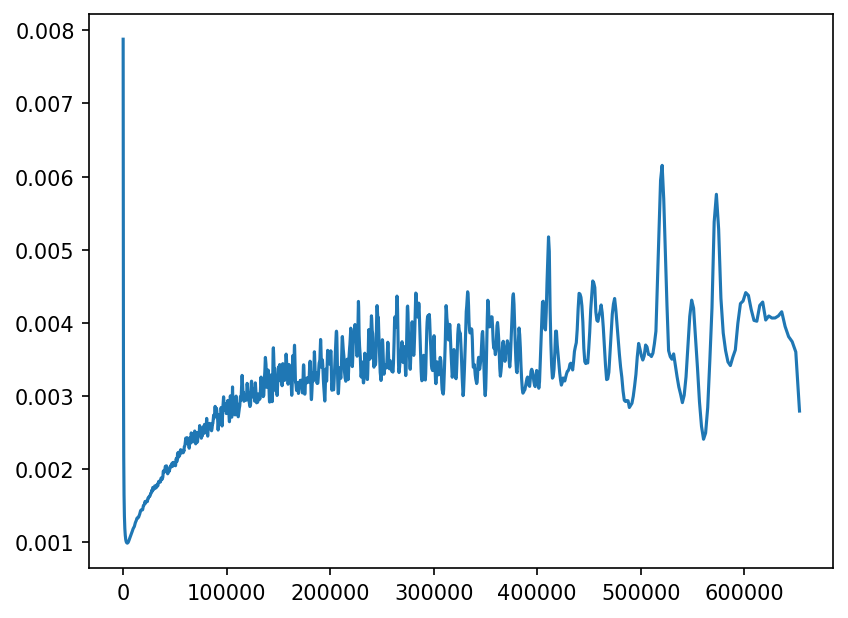

In [153]:
plt.plot(x, y)

In [117]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [118]:
kernel = 1 * RBF(length_scale=1, length_scale_bounds="fixed")
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,alpha=1e-6)
gaussian_process.fit(lx[:, None], y)
gaussian_process.kernel_

/home/ashmat/miniconda3-vesta/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.00316**2 * RBF(length_scale=1)

In [119]:
xs = np.linspace(lx[0], lx[-1], 100)
mean_prediction, std_prediction = gaussian_process.predict(xs[:, None], return_std=True)

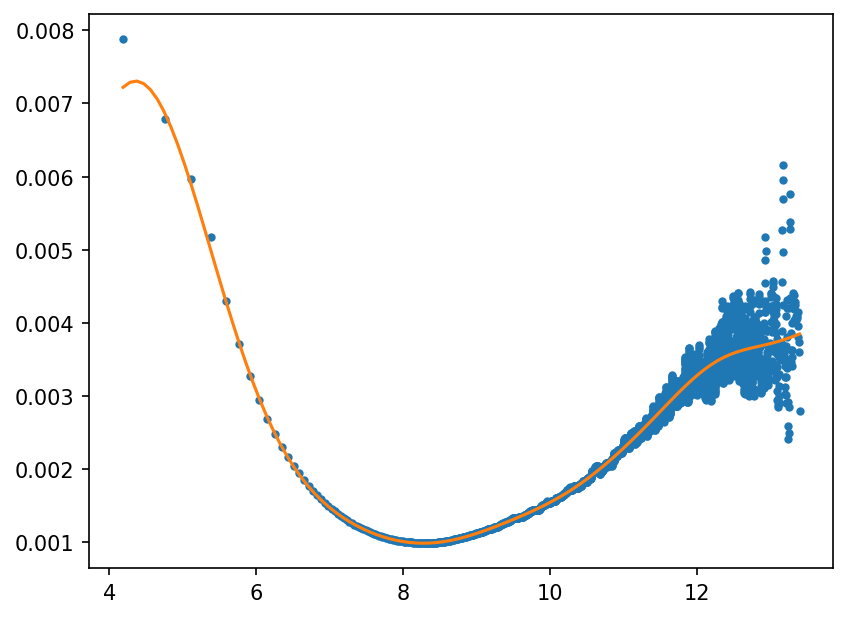

In [123]:
plt.plot(lx, y, lw=0, marker=".")
plt.plot(xs, mean_prediction, label="Mean prediction")

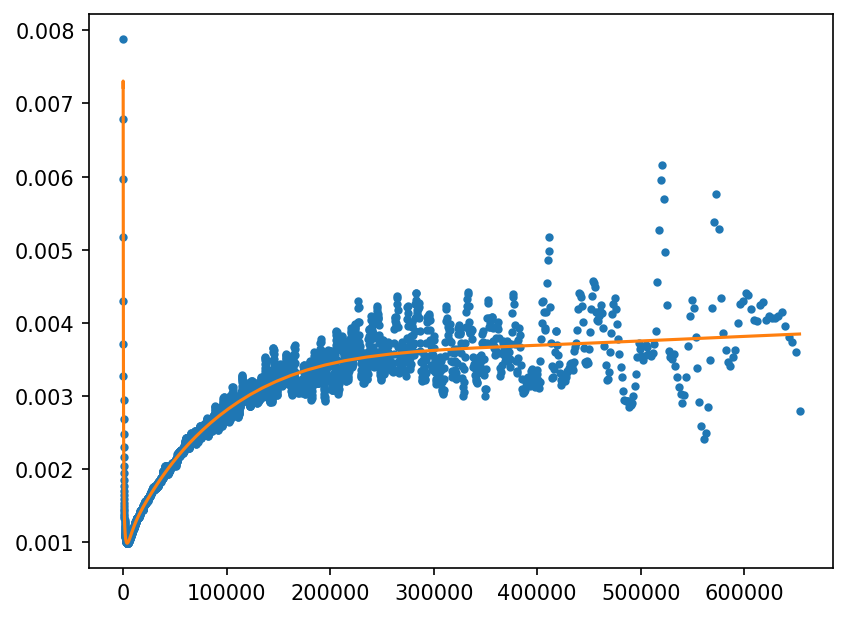

In [120]:
plt.plot(x, y, lw=0, marker=".")
plt.plot(np.exp(xs), mean_prediction, label="Mean prediction")

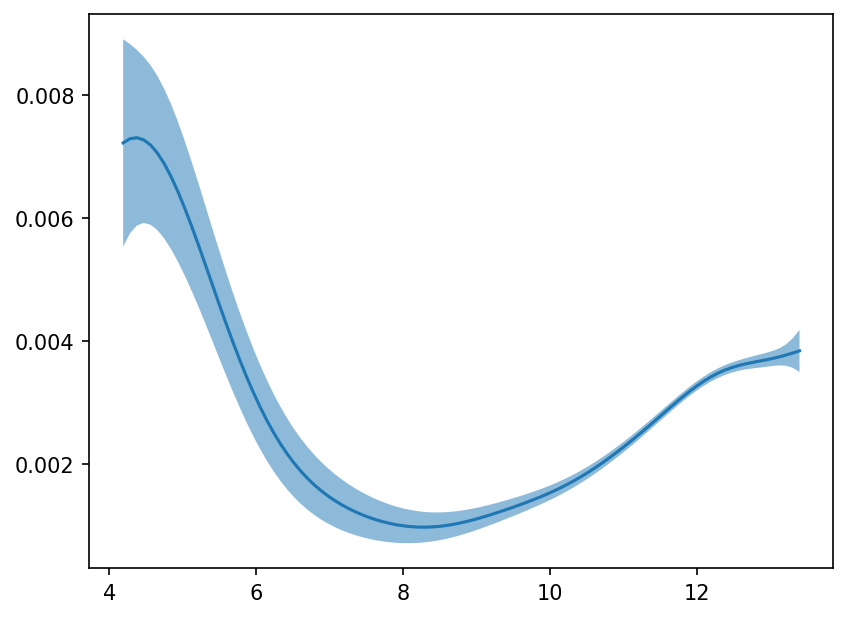

In [121]:
plt.plot(xs, mean_prediction, label="Mean prediction")
plt.fill_between(
    xs,
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)